# Airbnb price prediction

## Seasonality explotarion from RevPAR open data
We start exploring the seasonality from open available data. We will analyze the effect of:
* Daily RevPAR from  Airbnb listings
* National holidays in Peru
* Day of the week
* Assumptions on bridge days (long weekends)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import Airbnb RevPAR data of Chaclacayo - Peru
df_revPAR = pd.read_excel('seasonality_chacla.xlsx', sheet_name='RevPAR')
df_revPAR['Date'] = pd.to_datetime(df_revPAR['Date'])
df_revPAR['CW'] = df_revPAR['Date'].dt.isocalendar().week

# Normalize numeric values
df_revPAR['n_RevPAR']=(df_revPAR['RevPAR']-df_revPAR['RevPAR'].min())\
    /(df_revPAR['RevPAR'].max()-df_revPAR['RevPAR'].min())

df_revPAR.head()

,Date,RevPAR,Day,CW,n_RevPAR
0,2021-08-01,601,Sunday,30,0.672316
1,2021-08-02,520,Monday,31,0.557910
2,2021-08-03,508,Tuesday,31,0.540960
3,2021-08-04,534,Wednesday,31,0.577684
4,2021-08-05,540,Thursday,31,0.586158


In [3]:
# Import National holidays in Peru
df_holidays = pd.read_excel('seasonality_chacla.xlsx', sheet_name='Holidays')
df_holidays['Date'] = pd.to_datetime(df_holidays['Date'])
df_holidays['CW'] = df_holidays['Date'].dt.isocalendar().week
df_holidays['Day']= df_holidays['Date'].dt.day_name()

# Add bridge days:
# * Friday after a holiday in Thursday
for index, row in df_holidays.iterrows():
    if row['Day']=='Thursday' and row['Date'] + pd.Timedelta(days=1) not in df_holidays['Date'].values:
        temp = pd.DataFrame({'Date': [row['Date'] + pd.Timedelta(days=1)], 'Holiday': ['bridge day']})
        temp['CW'] = row['CW']
        temp['Day'] = 'Friday'
        df_holidays = pd.concat([df_holidays, temp], axis=0)
        df_holidays.sort_values(by='Date', inplace=True)
        df_holidays.reset_index(drop=True, inplace=True)
        del temp

df_holidays.head(20)

,Date,Holiday,CW,Day
0,2021-08-30,Santa Rosa de Lima,35,Monday
1,2021-10-08,Combate Naval de Angamos,40,Friday
2,2021-11-01,Día de todos los Santos,44,Monday
3,2021-12-08,Inmaculada Concepción,49,Wednesday
4,2021-12-09,Batalla de Ayacucho,49,Thursday
5,2021-12-10,bridge day,49,Friday
6,2021-12-25,Navidad,51,Saturday
7,2022-01-01,Año Nuevo,52,Saturday
8,2022-04-14,Jueves Santo,15,Thursday
9,2022-04-15,Viernes Santo,15,Friday


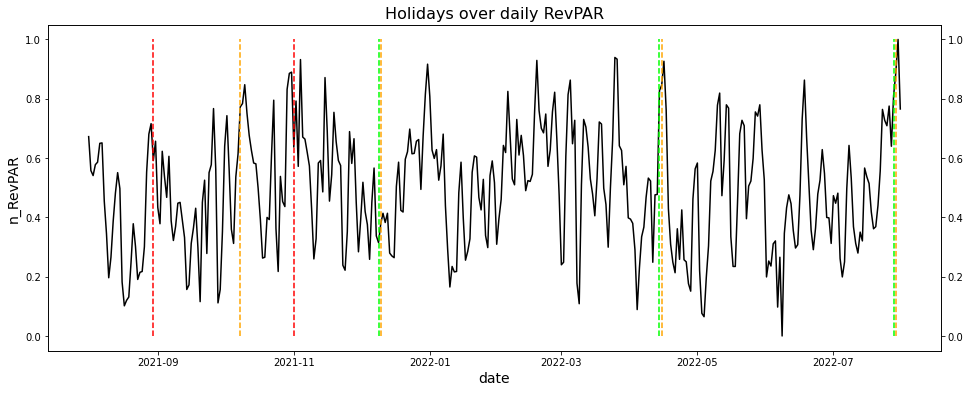

In [4]:
# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(16, 6))

# RevPAR
ax.plot(df_revPAR['Date'], df_revPAR['n_RevPAR'], color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("n_RevPAR", color="black", fontsize=14)
# Holidays
ax2=ax.twinx()
ax2.vlines(x=df_holidays[df_holidays.Day == 'Monday']['Date'], ymin=0, ymax=1, color="r", linestyles='dashed')
ax2.vlines(x=df_holidays[df_holidays.Day == 'Friday']['Date'], ymin=0, ymax=1, color="orange", linestyles='dashed')
ax2.vlines(x=df_holidays[df_holidays.Day == 'Thursday']['Date'], ymin=0, ymax=1, color="lime", linestyles='dashed')

plt.title('Holidays over daily RevPAR', fontsize = 16)
plt.show()

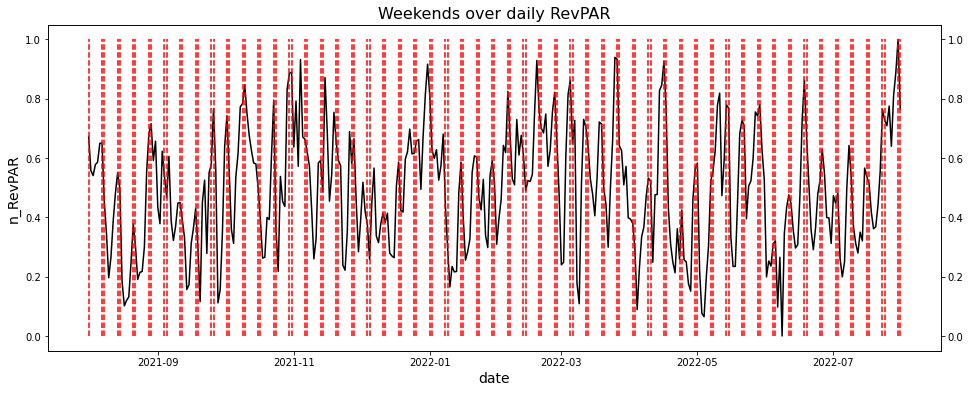

In [5]:
# Now we analyze the effect of weekends
weekends = pd.bdate_range(start="2021-08-01", end="2022-07-31", freq="C", weekmask="Sat Sun")

# We plot RevPAR & holidays
fig, ax = plt.subplots(figsize=(16, 6))

# RevPAR
ax.plot(df_revPAR['Date'], df_revPAR['n_RevPAR'], color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("n_RevPAR", color="black", fontsize=14)
# Holidays
ax2=ax.twinx()
ax2.vlines(x=weekends, ymin=0, ymax=1, color="r", linestyles='dashed')

plt.title('Weekends over daily RevPAR', fontsize = 16)
plt.show()

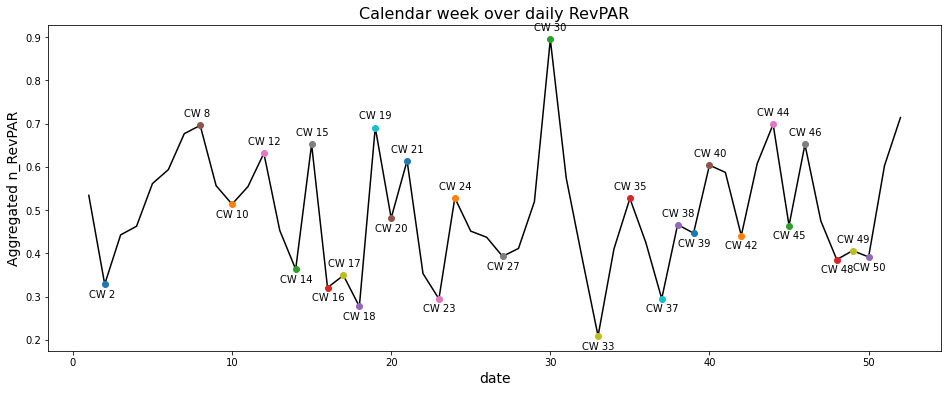

In [6]:
# Calculate aggregated RevPAR per Calendar Week
cw_df_revPAR = df_revPAR.groupby(df_revPAR.CW)['n_RevPAR'].sum()/7

dates = np.array(cw_df_revPAR.index.tolist())
returns = np.array(cw_df_revPAR.values.tolist())

# Calculate the minimas and the maximas
minimas = (np.diff(np.sign(np.diff(returns))) > 0).nonzero()[0] + 1 
maximas = (np.diff(np.sign(np.diff(returns))) < 0).nonzero()[0] + 1

# We plot RevPAR
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(cw_df_revPAR, color="black", label="n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("Aggregated n_RevPAR", color="black", fontsize=14)

for minima in minimas:
    ax.plot(minima+1, cw_df_revPAR.iloc[minima], marker="o")
    ax.annotate("CW " + str(minima+1),xy=(minima,cw_df_revPAR.iloc[minima]-0.03))
    
for maxima in maximas:
    ax.plot(maxima+1, cw_df_revPAR.iloc[maxima], marker="o")
    ax.annotate("CW " + str(maxima+1),xy=(maxima,cw_df_revPAR.iloc[maxima]+0.02))

plt.title('Calendar week over daily RevPAR', fontsize = 16)
plt.show()

## Observations
* Mondays & Fridays as holiday indicates a long weekend with high RevPAR
* Friday as bridge day don't indicate high RevPAR
* Thrusday as holiday indicates a long weekend and high RevPAR only during the Holy Week and Independence day (due to two days holidays in a row). Also, potentially this could apply for New Year's eve and Christmas.
* Weekends have a relative high RevPAR to their respective months
* Highest RevPAR is found in February & March, during the summer holidays; also then in Holy Week and school holidays. July is an exceptional month, by the end of December. Around October until the mid Nov RevPAR is also up.
* All other CW are either average or below average.

## Data exploration specific data
Now, we explore our specific house data. We analyze:
* Income per stay (without cleaning fees)
* Booking time in advance

In [7]:
# Import DB
df = pd.read_excel('Guest_Chaclacayo.xlsx', sheet_name='Reservas')

In [8]:
# convert dates column to DateTime
df['R_Date'] = pd.to_datetime(df['R_Date'])
df['R_CheckIn'] = pd.to_datetime(df['R_CheckIn'])
df['R_CheckOut'] = pd.to_datetime(df['R_CheckOut'])

# Replace NaN in R_Extra
df['R_Extra'] = df['R_Extra'].fillna(0)
df['R_DNI'] = df['R_DNI'].fillna(0)

# Change to Int
df['R_NumGuests'] = df['R_NumGuests'].astype(np.int64)
df['R_DNI'] = df['R_DNI'].astype(np.int64)

# Calculate, how much time in advance the house is booked
df['Adv_booked'] = df['R_CheckIn'] - df['R_Date']

# Calculate, for how long is the house booked
df['Days_booked'] = df['R_CheckOut'] - df['R_CheckIn']

# Normalize numeric values
df['n_R_Income']=(df['R_Income']-df['R_Income'].min())/(df['R_Income'].max()-df['R_Income'].min())

# Adding calendar weeks. For simpl., we base them in the R_CheckIn date; even if they stay longer than a week.
df['CW'] = df['R_CheckIn'].dt.isocalendar().week

df.head()

,R_ID,R_Date,R_CheckIn,R_CheckOut,R_NumGuests,R_Shifted,R_Car,R_Pet,R_Income,R_Extra,R_Guest,R_DNI,R_Comments,Adv_booked,Days_booked,n_R_Income,CW
0,Chacla0001,2021-12-31,2021-12-31,2022-01-02,10,False,True,False,1775.0,0.0,Tommy Baldeon,0,NaN,0 days,2 days,0.184785,52
1,Chacla0002,2022-01-05,2022-01-05,2022-01-07,5,True,True,False,1086.0,0.0,augusto quispe,10323589,NaN,0 days,2 days,0.044259,1
2,Chacla0003,2022-01-07,2022-01-07,2022-01-09,6,False,True,False,1086.0,0.0,gebsabella campos,0,NaN,0 days,2 days,0.044259,1
3,Chacla0004,2022-01-07,2022-01-14,2022-01-16,8,False,True,False,869.0,0.0,NaN,0,NaN,7 days,2 days,0.000000,2
4,Chacla0005,2022-01-07,2022-01-18,2022-01-20,8,False,True,False,1032.0,0.0,NaN,0,NaN,11 days,2 days,0.033245,3


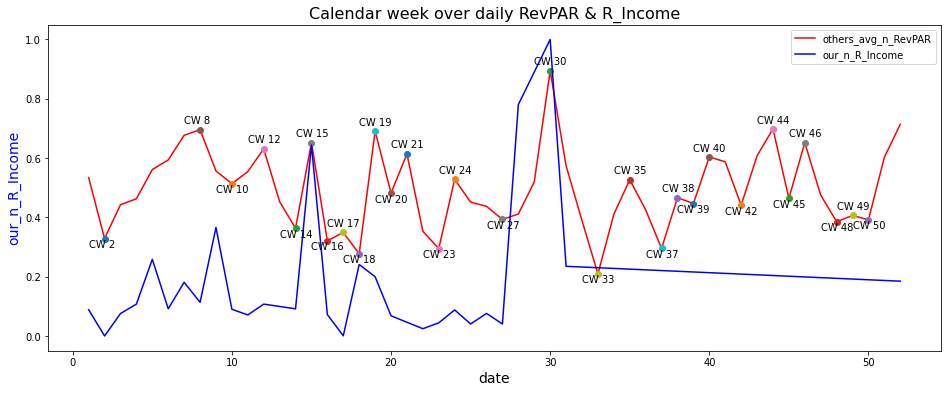

In [65]:
# We plot RevPAR
fig, ax = plt.subplots(figsize=(16, 6))

ax.plot(cw_df_revPAR, color="red", label="others_avg_n_RevPAR")
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("others_avg_n_RevPAR", color="red", fontsize=14)

for minima in minimas:
    ax.plot(minima+1, cw_df_revPAR.iloc[minima], marker="o")
    ax.annotate("CW " + str(minima+1),xy=(minima,cw_df_revPAR.iloc[minima]-0.03))
    
for maxima in maximas:
    ax.plot(maxima+1, cw_df_revPAR.iloc[maxima], marker="o")
    ax.annotate("CW " + str(maxima+1),xy=(maxima,cw_df_revPAR.iloc[maxima]+0.02))

# Calculate weekly income
cw_df = df.groupby(df.CW)['n_R_Income'].sum()

# We plot weekly income
ax.plot(cw_df, color="blue", label="our_n_R_Income")
ax.set_ylabel("our_n_R_Income", color="blue", fontsize=14)

plt.title('Calendar week over daily RevPAR & R_Income', fontsize = 16)
plt.legend()
plt.show()

In [56]:
# Import Airbnb Booking Lead Time - BLT
df_BLT = pd.read_excel('seasonality_chacla.xlsx', sheet_name='BLT')
df_BLT.rename(columns={"Booking_Lead_Time (days)": "BLT_days"}, inplace=True)
df_BLT['btl_Month'] = pd.to_datetime(df_BLT['Month']).dt.month
df_BLT.sort_values('btl_Month', inplace=True)
df_BLT.head(12)

,Month,BLT_days,btl_Month
5,2022-01,15,1
6,2022-02,16,2
7,2022-03,11,3
8,2022-04,19,4
9,2022-05,14,5
10,2022-06,15,6
11,2022-07,90,7
0,2021-08,18,8
1,2021-09,15,9
2,2021-10,16,10


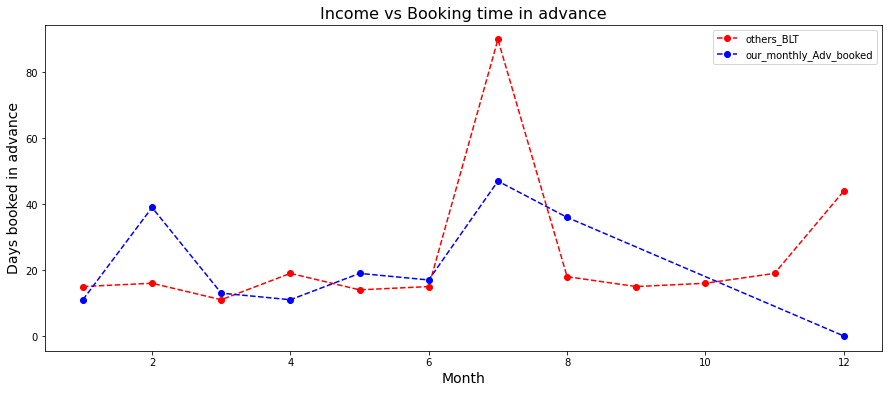

In [61]:
# We find the BLT per month
m_df = df.groupby(pd.DatetimeIndex(df['R_CheckIn']).month)['Adv_booked'].mean().dt.days

# We plot
fig, ax = plt.subplots(figsize=(15, 6))

ax.plot(df_BLT['btl_Month'], df_BLT['BLT_days'], 'o--', color="red", label="others_BLT")
ax.plot(m_df.index, m_df, 'o--', color="blue", label="our_monthly_Adv_booked")

ax.set_xlabel("Month", fontsize = 14)
ax.set_ylabel("Days booked in advance", color="black", fontsize=14)

plt.title('Income vs Booking time in advance', fontsize = 16)
plt.legend()
plt.show()

## Observations
* Our income for Holy Week and Independence Day followed a similar peak than the average.
* Nevertheless, our dips are stronger than the average. Thus, either we have stronger pricing power on these holidays than the average or we are not charging enough during the off peak weeks.